### 1. Data pre-processing

Creates an RDD from a csv file of ~570,000 product reviews. Goal is to use binary classification to predict if the customer is satisfied or unsatisfied. 

We perform 3 experiments: (1) compare the Hashing function vs. Count Vectorizer in the ML Pipeline for different values of N; (2) assess if the extra accuracy from adding bigrams is worth the extra computational time; (3) evaluate the effect of different training set sizes on accuracy.

In [1]:
dirPath = 'hdfs://saltdean/data/reviews/Reviews.csv'
review_data = sc.textFile(dirPath)
review_data.take(2)

['Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text',
 '1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.']

In [2]:
header = review_data.first() #Extract the header and drop it
review_data= review_data.filter(lambda x: x != header) 
review_data = review_data.map(lambda l: l.split(",")) #Split the csv file
review_data = review_data.map(lambda x: (x[6], x[8].lower(), x[9].lower())) #Keep score, summary and review
print(review_data.count())
labels = ['1', '2', '3', '4', '5'] #Filter out the nonsense values
review_data = review_data.filter(lambda x: x[0] in labels)
print(review_data.count())
review_data.take(1)

568454
565938


[('5',
  'good quality dog food',
  'i have bought several of the vitality canned dog food products and have found them all to be of good quality. the product looks more like a stew than a processed meat and it smells better. my labrador is finicky and she appreciates this product better than  most.')]

In [3]:
#Treat 4 and 5 as satisfied customers; 1, 2 and 3 as unsatisfied:
def satisfied(x):
    if x == '1' or x == '2' or x == '3':
        return 'unsatisfied'
    elif x == '4' or x == '5':
        return 'satisfied'
    else:
        return 'error'
    
review_data = review_data.map(lambda x: (satisfied(x[0]), x[1], x[2]))

In [4]:
import nltk
import re
from nltk.corpus import stopwords
nltk.download('punkt') # this loads the standard NLTK tokenizer model

def tokenize(data): # Tokenize, remove punctuation
    """ Apply the nltk.word_tokenize() method to our text, return the token list. """
    tokens = data.map(lambda x: (x[0], nltk.word_tokenize(x[1]), nltk.word_tokenize(x[2])))
    tokens = tokens.map(lambda x:(x[0], [re.sub('[^A-Za-z0-9]','',s) for s in x[1]], [re.sub('[^A-Za-z0-9]','',s) for s in x[2]]))
    tokens = tokens.map(lambda x: (x[0],[s for s in x[1] if len(s) > 0],[s for s in x[2] if len(s) > 0])) 
    return tokens 

review_data = tokenize(review_data)
review_data = review_data.map(lambda x: (x[0], x[1]+x[2])) #merge the summary and review columns

[nltk_data] Downloading package punkt to
[nltk_data]     /home/enterprise.internal.city.ac.uk/acvn474/nltk_data
[nltk_data]     ...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
review_data_small = sc.parallelize(review_data.take(10000)) #Make a subset to ensure everything runs smoothly.

### 2. Create a Spark DataFrame to run the ML pipeline

In [5]:
from pyspark.sql import Row
from pyspark.sql import SparkSession 
from pyspark.sql.types import DoubleType
import itertools

row_RDD = review_data.map(lambda x: Row(text=x[1], score=(x[0])))

spark = SparkSession.builder.appName("PythonSQL").config("spark.some.config.option", "some-value").getOrCreate()

#Create a dataFrame from the RDD:
df = spark.createDataFrame(row_RDD) # create the data frame, like in the lecture
#df = df.withColumn("label", df.score.cast("double"))

#Make a temp view to run SQL commands:
df.createOrReplaceTempView("temp_reviews") 
df.printSchema() # print the schema

SQL1 = "SELECT * FROM temp_reviews WHERE score == 'satisfied'"
score_satisfied = spark.sql(SQL1)
print(SQL1)
score_satisfied.show(5)

SQL3 = "SELECT * FROM temp_reviews WHERE score == 'unsatisfied'"
score_unsatisfied = spark.sql(SQL3)
print(SQL3)
score_unsatisfied.show(5)

root
 |-- score: string (nullable = true)
 |-- text: array (nullable = true)
 |    |-- element: string (containsNull = true)

SELECT * FROM temp_reviews WHERE score == 'satisfied'
+---------+--------------------+
|    score|                text|
+---------+--------------------+
|satisfied|[good, quality, d...|
|satisfied|[delight, says, i...|
|satisfied|[great, taffy, gr...|
|satisfied|[nice, taffy, i, ...|
|satisfied|[great, just, as,...|
+---------+--------------------+
only showing top 5 rows

SELECT * FROM temp_reviews WHERE score == 'unsatisfied'
+-----------+--------------------+
|      score|                text|
+-----------+--------------------+
|unsatisfied|[not, as, adverti...|
|unsatisfied|[cough, medicine,...|
|unsatisfied|[my, cats, are, n...|
|unsatisfied|[poor, taste, i, ...|
|unsatisfied|[nasty, no, flavo...|
+-----------+--------------------+
only showing top 5 rows



In [6]:
# Split the data into training and test sets from the dataframe using randomSplit 
# The training data will be divided again later for training/validation
# Create 3 training sets: 60%, 20%, 10%, and keep 15% for testing

#train1, test = df.randomSplit([0.8, 0.2], 20) # Split the data randomly, using 20 as the random seed to ensure reproducibility
train1, train2, train3, train4, train5, test = df.randomSplit([0.7, 0.07, 0.02, 0.009, 0.001, 0.2], 20)

In [18]:
#Display number of instances in each subset:
print("Size of training set: ", train1.count())
print("Size of training set 2: ", train2.count())
print("Size of training set 3: ", train3.count())
print("Size of training set 4: ", train4.count())
print("Size of training set 5: ", train5.count())
print("Size of test set: ", test.count())

Size of training set:  396137
Size of training set 2:  39434
Size of training set 3:  11376
Size of training set 4:  5150
Size of training set 5:  537
Size of test set:  113304


### 3. Experiment 1: comparing HashingTF vs. CountVectorizer for different vector lengths

In [11]:
from pyspark.ml.linalg import Vector
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import StopWordsRemover,VectorAssembler, NGram, HashingTF, CountVectorizer, Tokenizer, IDF, StringIndexer
from pyspark.ml.param import *
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

#Construct the pipeline:
def construct_pipeline(N):
    #Remove stopwords, but preserve the word "not"
    remover = StopWordsRemover().setInputCol("text").setOutputCol("filtered").setCaseSensitive(False)
    stopwordlist = remover.getStopWords()
    stopwordlist.remove('not')
    remover.setStopWords(stopwordlist)

    #Use HashingTF to hash the n-grams into a feature vector:
    hashing = HashingTF(numFeatures=N, inputCol="filtered", outputCol="tf")

    #Compare HashingTF vs. CountVectorizer:
    cv = CountVectorizer(vocabSize=N, inputCol="filtered", outputCol="tf")

    #We use IDF to rescale the feature vectors; this generally improves performance when using text as features.
    idf = IDF(inputCol='tf', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms

    #Transforms the satisfied/unsatisfied label into classes 0 or 1:
    label_stringIdx = StringIndexer(inputCol = "score", outputCol = "label")

    #Logistic Regression:
    lr = LogisticRegression().setElasticNetParam(0.0)

    #Connect the stages:
    #Pipeline 1: remove stopwords, hashing, idf, Logistic Regression
    pipeline1 = Pipeline(stages=[remover, hashing, idf, label_stringIdx, lr])

    #Pipeline 2: remove stopwords, use Count Vectorizer instead of hashing, idf, Logistic Regression
    pipeline2 = Pipeline(stages=[remover, cv, idf, label_stringIdx, lr])

    #Create parameter grid for parameter tuning:
    paramGridLR = ParamGridBuilder().addGrid(lr.regParam, [0.3, 0.1, 0.01]).build()

    #Divide the training data into train/validation, using 80% for training, 20% for validation.
    #Unlike cross-validation, only splits once:
    trainvalsplit1 = TrainValidationSplit(estimator=pipeline1,
                               estimatorParamMaps=paramGridLR,
                               evaluator=BinaryClassificationEvaluator(),
                               trainRatio=0.8).setSeed(123)

    trainvalsplit2 = TrainValidationSplit(estimator=pipeline2,
                               estimatorParamMaps=paramGridLR,
                               evaluator=BinaryClassificationEvaluator(),
                               trainRatio=0.8).setSeed(123)
    
    return trainvalsplit1, trainvalsplit2

In [12]:
tvs1, tvs2 = construct_pipeline(2**10)

In [13]:
%%time
# Fit the pipeline to the subset of training data to create a model for making predictions on the test set.
model1 = tvs1.fit(train1)

CPU times: user 400 ms, sys: 124 ms, total: 524 ms
Wall time: 34min 15s


In [14]:
%%time
model2 = tvs2.fit(train1)

CPU times: user 380 ms, sys: 180 ms, total: 560 ms
Wall time: 42min 52s


In [15]:
tvs3, tvs4 = construct_pipeline(2**12)

In [16]:
%%time
model3 = tvs3.fit(train1)

CPU times: user 360 ms, sys: 148 ms, total: 508 ms
Wall time: 33min 12s


In [17]:
%%time
model4 = tvs4.fit(train1)

CPU times: user 400 ms, sys: 156 ms, total: 556 ms
Wall time: 42min 19s


In [18]:
tvs5, tvs6 = construct_pipeline(2**13)

In [19]:
%%time
model5 = tvs5.fit(train1)

CPU times: user 320 ms, sys: 152 ms, total: 472 ms
Wall time: 33min 48s


In [20]:
%%time
model6 = tvs6.fit(train1)

CPU times: user 388 ms, sys: 136 ms, total: 524 ms
Wall time: 42min 23s


In [21]:
# Find the best set of parameters:
print("Model 1: ")
print("Best Regularization: ", model1.bestModel.stages[-1]._java_obj.getRegParam())
print("Best Elastic Net: ", model1.bestModel.stages[-1]._java_obj.getElasticNetParam())
print("Model 2: ")
print("Best Regularization: ", model2.bestModel.stages[-1]._java_obj.getRegParam())
print("Best Elastic Net: ", model2.bestModel.stages[-1]._java_obj.getElasticNetParam())
print("Model 3: ")
print("Best Regularization: ", model3.bestModel.stages[-1]._java_obj.getRegParam())
print("Best Elastic Net: ", model3.bestModel.stages[-1]._java_obj.getElasticNetParam())
print("Model 4: ")
print("Best Regularization: ", model4.bestModel.stages[-1]._java_obj.getRegParam())
print("Best Elastic Net: ", model4.bestModel.stages[-1]._java_obj.getElasticNetParam())
print("Model 5: ")
print("Best Regularization: ", model5.bestModel.stages[-1]._java_obj.getRegParam())
print("Best Elastic Net: ", model5.bestModel.stages[-1]._java_obj.getElasticNetParam())
print("Model 6: ")
print("Best Regularization: ", model6.bestModel.stages[-1]._java_obj.getRegParam())
print("Best Elastic Net: ", model6.bestModel.stages[-1]._java_obj.getElasticNetParam())

Model 1: 
Best Regularization:  0.01
Best Elastic Net:  0.0
Model 2: 
Best Regularization:  0.01
Best Elastic Net:  0.0
Model 3: 
Best Regularization:  0.01
Best Elastic Net:  0.0
Model 4: 
Best Regularization:  0.01
Best Elastic Net:  0.0
Model 5: 
Best Regularization:  0.01
Best Elastic Net:  0.0
Model 6: 
Best Regularization:  0.01
Best Elastic Net:  0.0


In [22]:
#Returns a confusion matrix and various classification metrics given predictions on the test set.
import numpy as np

def eval_metrics(pred):
    C = np.empty([2,2])
    C[0,0] = pred.filter((pred.label == 0) & (pred.prediction == 0)).count()
    C[0,1] = pred.filter((pred.label == 0) & (pred.prediction == 1)).count()
    C[1,0] = pred.filter((pred.label == 1) & (pred.prediction == 0)).count()
    C[1,1] = pred.filter((pred.label == 1) & (pred.prediction == 1)).count()
    sumC = C.sum()
    accuracy = (C[0,0] + C[1,1])/sumC
    precision = C[1,1]/(C[1,1] + C[0,1])
    recall = C[1,1]/(C[1,1] + C[1,0])
    F1score = 2*(precision*recall)/(precision+recall)
    return C, accuracy, precision, recall, F1score

#Prints results on the test set:
def print_results(myModel):
    predictions = myModel.transform(test)
    C, acc, prec, rec, f1score = eval_metrics(predictions)
    print("Confusion matrix: ", "\n", C)
    print("Accuracy: {0:.4f}".format(acc))
    print("Precision: {0:.4f}".format(prec))
    print("Recall: {0:.4f}".format(rec))
    print("F1 score: {0:.4f}".format(f1score))
    print("ROC-AUC: {0:.4f}".format(evaluator.evaluate(predictions)), "\n")
    
#Prints results on the training set:
def print_training_results(myModel, myTrain):
    predictions = myModel.transform(myTrain)
    C, acc, prec, rec, f1score = eval_metrics(predictions)
    print("Confusion matrix: ", "\n", C)
    print("Accuracy: {0:.4f}".format(acc))
    print("Precision: {0:.4f}".format(prec))
    print("Recall: {0:.4f}".format(rec))
    print("F1 score: {0:.4f}".format(f1score))
    print("ROC-AUC: {0:.4f}".format(evaluator.evaluate(predictions)), "\n")

In [23]:
evaluator=BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
print("Logistic Regression using Hashing Vectorizer, N = 1024")
print_results(model1)
print("Logistic Regression using Count Vectorizer, N = 1024")
print_results(model2)
print("Logistic Regression using Hashing Vectorizer, N = 4096")
print_results(model3)
print("Logistic Regression using Count Vectorizer, N = 4096")
print_results(model4)
print("Logistic Regression using Hashing Vectorizer, N = 8192")
print_results(model5)
print("Logistic Regression using Count Vectorizer, N = 8192")
print_results(model6)

Logistic Regression using Hashing Vectorizer, N = 1024
Confusion matrix:  
 [[ 84497.   3705.]
 [ 14821.  10281.]]
Accuracy: 0.8365
Precision: 0.7351
Recall: 0.4096
F1 score: 0.5260
ROC-AUC: 0.8614 

Logistic Regression using Count Vectorizer, N = 1024
Confusion matrix:  
 [[ 84953.   3249.]
 [ 12514.  12588.]]
Accuracy: 0.8609
Precision: 0.7948
Recall: 0.5015
F1 score: 0.6150
ROC-AUC: 0.9000 

Logistic Regression using Hashing Vectorizer, N = 4096
Confusion matrix:  
 [[ 84677.   3525.]
 [ 11727.  13375.]]
Accuracy: 0.8654
Precision: 0.7914
Recall: 0.5328
F1 score: 0.6369
ROC-AUC: 0.9014 

Logistic Regression using Count Vectorizer, N = 4096
Confusion matrix:  
 [[ 84990.   3212.]
 [ 10537.  14565.]]
Accuracy: 0.8787
Precision: 0.8193
Recall: 0.5802
F1 score: 0.6794
ROC-AUC: 0.9189 

Logistic Regression using Hashing Vectorizer, N = 8192
Confusion matrix:  
 [[ 84641.   3561.]
 [ 10688.  14414.]]
Accuracy: 0.8742
Precision: 0.8019
Recall: 0.5742
F1 score: 0.6692
ROC-AUC: 0.9113 

Logi

### 4. Experiment 2: assessing the effect of adding bigrams

In [28]:
#Pipeline 3: add bigrams, do not remove stopwords, as it creates fake bigrams:
N = 2**13 #set N = 4096 per Experiment 1
ngram_uni = NGram().setN(1).setInputCol("text").setOutputCol("nGram1")
ngram_bi = NGram().setN(2).setInputCol("text").setOutputCol("nGram2")
cv_uni = CountVectorizer(vocabSize=N, inputCol="nGram1", outputCol="vector1")
cv_bi = CountVectorizer(vocabSize=N, inputCol="nGram2", outputCol="vector2")
idf_uni = IDF(inputCol='vector1', outputCol="features1", minDocFreq=5)
idf_bi = IDF(inputCol='vector2', outputCol="features2", minDocFreq=5)
assembler = VectorAssembler(inputCols=["features1", "features2"],outputCol="features")
label_stringIdx = StringIndexer(inputCol = "score", outputCol = "label")
lr = LogisticRegression().setElasticNetParam(0.0)
paramGridLR = ParamGridBuilder().addGrid(lr.regParam, [0.3, 0.1, 0.01]).build()
pipeline3 = Pipeline(stages=[ngram_uni, ngram_bi, cv_uni, cv_bi, idf_uni, idf_bi, assembler, label_stringIdx, lr])

tvs7 = TrainValidationSplit(estimator=pipeline3,
                           estimatorParamMaps=paramGridLR,
                           evaluator=BinaryClassificationEvaluator(),
                           trainRatio=0.8).setSeed(123)

In [29]:
%%time
# Fit the pipeline to the training data to create a model for making predictions on the test set.
model7 = tvs7.fit(train1)

CPU times: user 468 ms, sys: 168 ms, total: 636 ms
Wall time: 1h 16min 42s


In [30]:
print("Model 7: ")
print("Best Regularization: ", model7.bestModel.stages[-1]._java_obj.getRegParam())
print("Best Elastic Net: ", model7.bestModel.stages[-1]._java_obj.getElasticNetParam())
print("Logistic Regression using Count Vectorizer, N = 8192 with Bigrams")
print_results(model7)

Model 7: 
Best Regularization:  0.01
Best Elastic Net:  0.0
Logistic Regression using Count Vectorizer, N = 4096 with Bigrams
Confusion matrix:  
 [[ 85136.   3066.]
 [  7565.  17537.]]
Accuracy: 0.9062
Precision: 0.8512
Recall: 0.6986
F1 score: 0.7674
ROC-AUC: 0.9465 



### 5. Experiment 3: assessing the effect of different training set sizes

For faster iteration, we set Elastic Net Param to 0 as this gives the best results in all previous cases.

In [31]:
lr = LogisticRegression().setElasticNetParam(0.0)
paramGridLR = ParamGridBuilder().addGrid(lr.regParam, [0.3, 0.1, 0.01]).build()
pipeline4 = Pipeline(stages=[ngram_uni, ngram_bi, cv_uni, cv_bi, idf_uni, idf_bi, assembler, label_stringIdx, lr])
tvs8 = TrainValidationSplit(estimator=pipeline4,
                           estimatorParamMaps=paramGridLR,
                           evaluator=BinaryClassificationEvaluator(),
                           trainRatio=0.8).setSeed(123)

In [20]:
%%time
# Fit the pipeline to the full training data.
model8 = tvs8.fit(train1)

CPU times: user 500 ms, sys: 184 ms, total: 684 ms
Wall time: 1h 14min 49s


In [32]:
%%time
# Fit the pipeline to the 10% partition of training data.
model9 = tvs8.fit(train2)

CPU times: user 576 ms, sys: 196 ms, total: 772 ms
Wall time: 1h 11min 59s


In [33]:
%%time
# Fit the pipeline to the 1% partition of training data.
model10 = tvs8.fit(train3)

CPU times: user 684 ms, sys: 192 ms, total: 876 ms
Wall time: 1h 15min 32s


In [34]:
%%time
# Fit the pipeline to the 0.1% partition of training data.
model11 = tvs8.fit(train4)

CPU times: user 688 ms, sys: 252 ms, total: 940 ms
Wall time: 1h 15min 44s


In [35]:
%%time
# Fit the pipeline to the 0.01% partition of training data.
model12 = tvs8.fit(train5)

CPU times: user 832 ms, sys: 204 ms, total: 1.04 s
Wall time: 1h 14min 55s


In [36]:
model8 = model7

In [37]:
evaluator=BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
print("Model 8, n = 396,137:")
print("Best Regularization: ", model8.bestModel.stages[-1]._java_obj.getRegParam())
print("Best Elastic Net: ", model8.bestModel.stages[-1]._java_obj.getElasticNetParam())
print_results(model8)
print("Model 9, n = 39,434:")
print("Best Regularization: ", model9.bestModel.stages[-1]._java_obj.getRegParam())
print("Best Elastic Net: ", model9.bestModel.stages[-1]._java_obj.getElasticNetParam())
print_results(model9)
print("Model 10, n = 11,376:")
print("Best Regularization: ", model10.bestModel.stages[-1]._java_obj.getRegParam())
print("Best Elastic Net: ", model10.bestModel.stages[-1]._java_obj.getElasticNetParam())
print_results(model10)
print("Model 11, n = 5,150:")
print("Best Regularization: ", model11.bestModel.stages[-1]._java_obj.getRegParam())
print("Best Elastic Net: ", model11.bestModel.stages[-1]._java_obj.getElasticNetParam())
print_results(model11)
print("Model 12, n = 537:")
print("Best Regularization: ", model12.bestModel.stages[-1]._java_obj.getRegParam())
print("Best Elastic Net: ", model12.bestModel.stages[-1]._java_obj.getElasticNetParam())
print_results(model12)

Model 8, n = 396,137:
Best Regularization:  0.01
Best Elastic Net:  0.0
Confusion matrix:  
 [[ 85136.   3066.]
 [  7565.  17537.]]
Accuracy: 0.9062
Precision: 0.8512
Recall: 0.6986
F1 score: 0.7674
ROC-AUC: 0.9465 

Model 9, n = 39,434:
Best Regularization:  0.3
Best Elastic Net:  0.0
Confusion matrix:  
 [[ 86987.   1215.]
 [ 15110.   9992.]]
Accuracy: 0.8559
Precision: 0.8916
Recall: 0.3981
F1 score: 0.5504
ROC-AUC: 0.9207 

Model 10, n = 11,376:
Best Regularization:  0.3
Best Elastic Net:  0.0
Confusion matrix:  
 [[ 86924.   1278.]
 [ 16826.   8276.]]
Accuracy: 0.8402
Precision: 0.8662
Recall: 0.3297
F1 score: 0.4776
ROC-AUC: 0.8942 

Model 11, n = 5,150:
Best Regularization:  0.3
Best Elastic Net:  0.0
Confusion matrix:  
 [[ 87008.   1194.]
 [ 18288.   6814.]]
Accuracy: 0.8281
Precision: 0.8509
Recall: 0.2715
F1 score: 0.4116
ROC-AUC: 0.8711 

Model 12, n = 537:
Best Regularization:  0.01
Best Elastic Net:  0.0
Confusion matrix:  
 [[ 80335.   7867.]
 [ 16510.   8592.]]
Accuracy

This prints training results for the various training sets.

In [38]:
print("Model 8, n = 396,137:")
print_training_results(model8, train1)
print("Model 9, n = 39,434:")
print_training_results(model9, train2)
print("Model 10, n = 11,376:")
print_training_results(model10, train3)
print("Model 11, n = 5,150:")
print_training_results(model11, train4)
print("Model 12, n = 537:")
print_training_results(model12, train5)

Model 8, n = 396,137:
Confusion matrix:  
 [[ 300388.    8343.]
 [  23244.   64162.]]
Accuracy: 0.9203
Precision: 0.8849
Recall: 0.7341
F1 score: 0.8025
ROC-AUC: 0.9639 

Model 9, n = 39,434:
Confusion matrix:  
 [[ 30409.    152.]
 [  4285.   4588.]]
Accuracy: 0.8875
Precision: 0.9679
Recall: 0.5171
F1 score: 0.6741
ROC-AUC: 0.9739 

Model 10, n = 11,376:
Confusion matrix:  
 [[ 8804.    17.]
 [  937.  1618.]]
Accuracy: 0.9161
Precision: 0.9896
Recall: 0.6333
F1 score: 0.7723
ROC-AUC: 0.9911 

Model 11, n = 5,150:
Confusion matrix:  
 [[  4.03100000e+03   1.00000000e+00]
 [  3.98000000e+02   7.20000000e+02]]
Accuracy: 0.9225
Precision: 0.9986
Recall: 0.6440
F1 score: 0.7830
ROC-AUC: 0.9944 

Model 12, n = 537:
Confusion matrix:  
 [[ 412.    0.]
 [   2.  123.]]
Accuracy: 0.9963
Precision: 1.0000
Recall: 0.9840
F1 score: 0.9919
ROC-AUC: 1.0000 



### Appendix: optional cells to run to display various plots

In [ ]:
import pandas as pd
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from sklearn.metrics import roc_curve,auc
%matplotlib inline
import matplotlib.pyplot as plt

trainingSummary6 = model6.bestModel.transform(test)
model6results = trainingSummary6.select("probability", "label").toPandas()
trainingSummary7 = model7.bestModel.transform(test)
model7results = trainingSummary7.select("probability","label").toPandas()

# ROC
prob6 = model6results["probability"]
prob = prob6.map(lambda x: x[1])
labels = np.array(model6results['label'])
fpr2, tpr2, thresholds2 = roc_curve(labels, prob);
roc_auc2 = auc(fpr2, tpr2)
prob7 = model7results["probability"]
prob7 = prob7.map(lambda x: x[1])
labels7 = np.array(model7results['label'])
fpr7, tpr7, thresholds7 = roc_curve(labels7, prob7);
roc_auc7 = auc(fpr7, tpr7)

# PLOT
plt.figure(figsize=(5,5))
plt.plot(fpr2, tpr2, label='ROC, unigram only (area = %0.2f)' % roc_auc2)
plt.plot(fpr7, tpr7, label='ROC, uni + bigrams (area = %0.2f)' % roc_auc7)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Experiment 2: ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#Plot the number of each score:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
score_count = [review_data.filter(lambda x: x[0] == i).count() for i in labels]
scores = np.arange(1,6)
plt.bar(scores, score_count)
plt.xlabel('Review score')
plt.ylabel('Number of reviews')
plt.xticks(scores+0.5, labels)
plt.title('Number of reviews for each rating')
plt.show()

In [ ]:
from nltk.corpus import stopwords
nltk_words = list(stopwords.words('english'))
nltk_words.extend(["br", "", "nt"])
nltk_words.remove("not")

from operator import add
from functools import partial
    
def reGrpLst(idscorengram_count): # we get a nested tuple
    id_ngram, count = idscorengram_count
    id_no, ngram = id_ngram
    return (id_no, [(ngram,count)]) 

def removeStops(tokenList): #Takes a list of tokens and removes stopwords
    cleanList = [w for w in tokenList if not w in nltk_words]
    return cleanList 

def splitScoreNGrams(scoreContent): # your splitting function 
    score,grams = scoreContent 
    scoreGramList = [] 
    for ngram in grams: 
        scoreGramList.append((score,ngram))
    return scoreGramList 

def sumWordCount(wordCountList): #given a list of tuples, sum the second value
    totalwords = 0
    normalized_list = []
    for word_count in wordCountList:
        word, count = word_count
        totalwords += count
    for word_count in wordCountList:
        word, count = word_count
        count = count/totalwords
        normalized_list.append((word, count))
    return normalized_list

rdd1 = review_data.map(lambda x: (x[0], removeStops(x[1]))) 
rdd2 = rdd1.flatMap(partial(lambda x: splitScoreNGrams(x)))
rdd3 = rdd2.map(lambda x: (x, 1)) #Append 1 to each tuple
rdd4 = rdd3.reduceByKey(add) #Sum by ngram
rdd5 = rdd4.map(reGrpLst) #Regroup to (score, [word, count])
rdd6 = rdd5.reduceByKey(add) #Sum by score
rdd7 = rdd6.map(lambda y: (y[0], sorted(y[1], key=lambda x: x[1], reverse=True)))
rdd8 = rdd7.map(lambda x: (x[0], sumWordCount(x[1])))
rdd9 = rdd8.map(lambda x: (x[0], x[1][:10])) #Keep the first 10 words of each score
rdd9.take(5)

In [40]:
n = [396137, 39434, 11376, 5150, 537]
trg_acc = [.9203, .8875, .9161, .9225, .9963]
test_acc = [.906, .8559, .8402, .828, .7849]
trg_auc = [.9639, .9739, .9911, .9944, 1]
test_auc = [.947, .921, .8942, .8714, .7481]

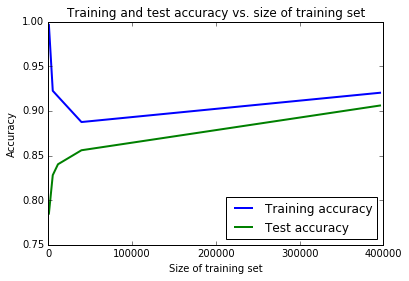

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(n, trg_acc, label="Training accuracy", linewidth=2)
plt.plot(n, test_acc, label="Test accuracy", linewidth=2)
plt.xlabel("Size of training set")
plt.ylabel("Accuracy")
plt.title("Training and test accuracy vs. size of training set")
plt.legend(loc="lower right")
plt.xticks([0, 100000, 200000, 300000, 400000])
plt.show()

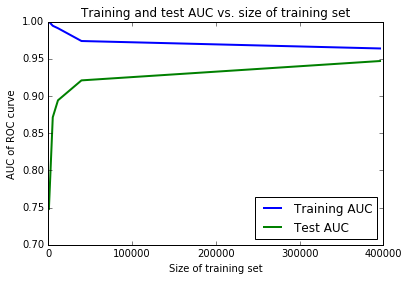

In [42]:
plt.plot(n, trg_auc, label="Training AUC", linewidth=2)
plt.plot(n, test_auc, label="Test AUC", linewidth=2)
plt.xlabel("Size of training set")
plt.ylabel("AUC of ROC curve")
plt.title("Training and test AUC vs. size of training set")
plt.legend(loc="lower right")
plt.xticks([0, 100000, 200000, 300000, 400000])
plt.show()